## Title: Fraud Detection System for Financial Security: Project for ABC Bank

#### Problem Statement: 
The objective of this project is to design a fraud detection system that effectively identifies and flags suspicious transactions for ABC Bank. By implementing an accurate and robust fraud detection system, the bank aims to minimize financial losses, maintain trust with customers, and ensure the security of transactions.              

### Data Exploration

In [47]:
#importing necessary liabraries.
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#reading dataset.
df=pd.read_csv(r'E:\learntube\project\fraud detection\fraud detection.csv')
df.head()

,Transaction_ID,Customer_ID,Transaction_Amount,Location,Time_of_Day,Is_Fraudulent
0,1,101,1000,Mumbai,Morning,0
1,2,102,500,Delhi,Afternoon,1
2,3,103,2000,Chennai,Evening,0
3,4,104,300,Gujarat,Morning,1
4,5,105,800,Bengalore,Afternoon,0


#### The dataset contains the following fields:
1. Transaction_ID: Unique identifier for each transaction.
2. Customer_ID: Unique identifier for each customer.
3. Transaction_Amount: The amount of money involved in the transaction.
4. Location: The geographical location where the transaction took place (e.g., Mumbai, Delhi).
5. Time_of_Day: The part of the day during which the transaction occurred (e.g., Morning, Afternoon, Evening).
6. Is_Fraudulent: A binary label indicating whether the transaction was fraudulent (1) or not (0).
In this example, there are transactions with a mix of fraudulent and non-fraudulent labels.


### Exploratory Data Analysis

In [3]:
#size of the dataset.
df.shape

(20, 6)

In [4]:
#info of Dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Transaction_ID      20 non-null     int64 
 1   Customer_ID         20 non-null     int64 
 2   Transaction_Amount  20 non-null     int64 
 3   Location            20 non-null     object
 4   Time_of_Day         20 non-null     object
 5   Is_Fraudulent       20 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 1.1+ KB


In [5]:
#checking null values.
df.isnull().sum()

Transaction_ID        0
Customer_ID           0
Transaction_Amount    0
Location              0
Time_of_Day           0
Is_Fraudulent         0
dtype: int64

No null records are found here so we can proceed further for data viualization. 

In [6]:
#checking if null values are present.
df.nunique()

Transaction_ID        20
Customer_ID           20
Transaction_Amount    17
Location               5
Time_of_Day            3
Is_Fraudulent          2
dtype: int64

In [7]:
#checking unique values for loaction column.
df['Location'].unique()

array(['Mumbai', 'Delhi', 'Chennai', 'Gujarat', 'Bengalore'], dtype=object)

In [8]:
#chaking unique values for time of day column.
df['Time_of_Day'].unique()

array(['Morning', 'Afternoon', 'Evening'], dtype=object)

Since we only have 20 records and both the Transaction_ID and Customer_ID columns contain unique values for each entry, we cannot create meaningful customer or transaction-related features. Therefore, these two columns are not useful for analysis and can be dropped.

### Data Preprocessing.

In [9]:
#dropping unnecessary columns.
df=df.drop(['Transaction_ID','Customer_ID'],axis=1)
df

,Transaction_Amount,Location,Time_of_Day,Is_Fraudulent
0,1000,Mumbai,Morning,0
1,500,Delhi,Afternoon,1
2,2000,Chennai,Evening,0
3,300,Gujarat,Morning,1
4,800,Bengalore,Afternoon,0
5,1500,Mumbai,Evening,1
6,400,Delhi,Morning,0
7,2500,Chennai,Afternoon,1
8,700,Gujarat,Evening,0
9,1200,Bengalore,Morning,0


In [10]:
#statistical analysis.
df.describe()

,Transaction_Amount,Is_Fraudulent
count,20.000000,20.000000
mean,1192.500000,0.400000
std,787.112478,0.502625
min,300.000000,0.000000
25%,500.000000,0.000000
50%,950.000000,0.000000
75%,1725.000000,1.000000
max,3000.000000,1.000000


### Insights
* Mean transaction amount: ₹1192
* Minimum transaction amount: ₹300
* Maximum transaction amount: ₹3000

### Feature engineering.

In [11]:
#Apply log transformation to Transaction_Amount to handle skewness or outliers. and adding as new column.
df['Log_Transaction_Amount'] = np.log(df['Transaction_Amount'] + 1)

#creating flag for high risk transcation if the transaction amt is more than avg.
df['High_Risk'] = df['Transaction_Amount'].apply(lambda x: 1 if x > 1192 else 0)

#combining location and time of the day column.
df['Location_Time'] = df['Location'] + '_' + df['Time_of_Day']

# Calculating fraud counts for each Location_Time combination
fraud_counts = df.groupby('Location_Time')['Is_Fraudulent'].value_counts().unstack().fillna(0)

#Calculating risk score based on counts of fraudulent transactions
# Assuming we want to give scores based on the ratio of fraudulent to total transactions
fraud_counts['Total'] = fraud_counts[0] + fraud_counts[1]  # Total transactions
fraud_counts['Risk_Score'] = (fraud_counts[1] / fraud_counts['Total']).fillna(0) * 3 

# Mapping the Risk_Score back to the original DataFrame
risk_mapping = fraud_counts['Risk_Score'].to_dict()
df['Risk_Score'] = df['Location_Time'].map(risk_mapping)

df

,Transaction_Amount,Location,Time_of_Day,Is_Fraudulent,Log_Transaction_Amount,High_Risk,Location_Time,Risk_Score
0,1000,Mumbai,Morning,0,6.908755,0,Mumbai_Morning,0.0
1,500,Delhi,Afternoon,1,6.216606,0,Delhi_Afternoon,1.5
2,2000,Chennai,Evening,0,7.601402,1,Chennai_Evening,0.0
3,300,Gujarat,Morning,1,5.707110,0,Gujarat_Morning,3.0
4,800,Bengalore,Afternoon,0,6.685861,0,Bengalore_Afternoon,0.0
5,1500,Mumbai,Evening,1,7.313887,1,Mumbai_Evening,3.0
6,400,Delhi,Morning,0,5.993961,0,Delhi_Morning,0.0
7,2500,Chennai,Afternoon,1,7.824446,1,Chennai_Afternoon,3.0
8,700,Gujarat,Evening,0,6.552508,0,Gujarat_Evening,0.0
9,1200,Bengalore,Morning,0,7.090910,1,Bengalore_Morning,0.0


### Data Visualization

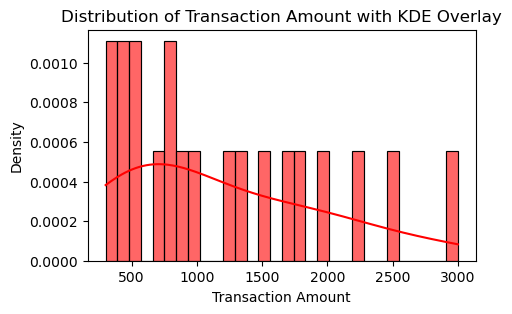

In [12]:
# Create a histogram with KDE overlay 
plt.figure(figsize=(5, 3)) 
sns.histplot(df['Transaction_Amount'], bins=30, kde=True, color='red', stat='density', alpha=0.6) 
plt.title('Distribution of Transaction Amount with KDE Overlay') 
plt.xlabel('Transaction Amount') 
plt.ylabel('Density')
plt.show()

#### Insights:
1. Bimodal Distribution: The histogram shows two peaks in transaction amounts, with a concentration around 500-1000 and another around 1000-1500.
2. Frequency: Most transactions are in the lower range, indicating smaller transaction amounts are more common, while higher amounts (above 1500) are less frequent.
3. KDE Curve: The KDE closely follows the histogram, confirming the observed peaks.
4. Outliers: Higher transaction amounts (e.g., above 2000) may require further investigation for potential fraud.


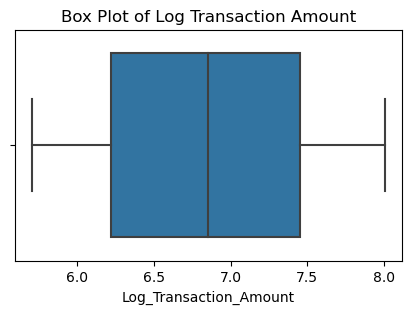

In [13]:
#creating box plot for log transaction amt.
plt.figure(figsize=(5, 3)) 
sns.boxplot(data=df,x='Log_Transaction_Amount')
plt.title('Box Plot of Log Transaction Amount')
plt.show()

### Insights:
1. Central Tendency: The median of the logged values indicates a central concentration of transaction amounts.
2. Low Variability: The interquartile range (IQR) is compact, suggesting low variability in the middle 50% of the data.
3. No Outliers: There are no points outside the whiskers, indicating the absence of outliers.
4. Consistent Range: The whiskers show that transaction amounts are consistently distributed without extreme values.

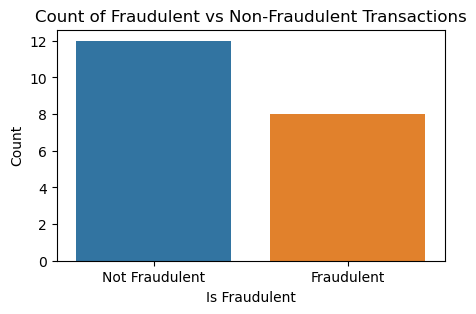

In [14]:
#creating count plot for fraud or no fraud transcation.
plt.figure(figsize=(5, 3)) 
sns.countplot(x='Is_Fraudulent', data=df) 
plt.title('Count of Fraudulent vs Non-Fraudulent Transactions') 
plt.xlabel('Is Fraudulent') 
plt.ylabel('Count') 
plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent']) 
plt.show()

### Insights
The chart highlights a class imbalance in the dataset, with a higher prevalence of non-fraudulent transactions. Further analysis is needed to understand the characteristics of fraudulent and non-fraudulent transactions and develop effective fraud detection models.

<Figure size 300x200 with 0 Axes>

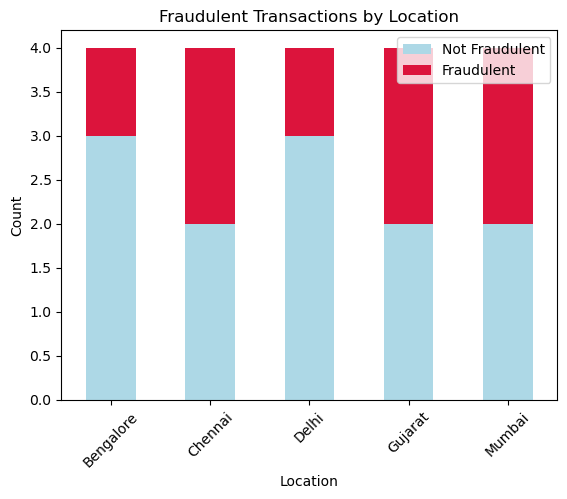

In [15]:
#Visualize how the count of fraudulent and non-fraudulent transactions varies across different locations.
plt.figure(figsize=(3,2))
colors = ['lightblue', 'crimson']
location_fraud_count = df.groupby(['Location', 'Is_Fraudulent']).size().unstack() 
location_fraud_count.plot(kind='bar', stacked=True,color=colors) 
plt.title('Fraudulent Transactions by Location') 
plt.xlabel('Location') 
plt.ylabel('Count') 
plt.xticks(rotation=45) 
plt.legend(labels=['Not Fraudulent', 'Fraudulent']) 
plt.show()

### Insight

#### Overall Fraudulent Activity:
The chart provides a clear overview of fraudulent and non-fraudulent transactions across different locations.
The stacked bar format allows for easy comparison of the proportions of fraudulent and non-fraudulent transactions in each location.

#### Location-Specific Trends:
* Bangalore: While having a relatively high number of total transactions, Bangalore also exhibits a significant proportion of fraudulent activity.
* Chennai: Chennai shows a somewhat lower level of fraudulent transactions compared to Bangalore.
* Delhi: Delhi also has a moderate level of fraudulent activity.
* Gujarat: Gujarat appears to have the lowest proportion of fraudulent transactions among the locations analyzed.
* Mumbai: Mumbai's fraudulent activity level is comparable to Delhi, with a moderate proportion of fraudulent transactions.

#### Overall
The visualization provides insights into the distribution of fraudulent transactions across different locations. It shows that there are regional variations in fraudulent activity, with some locations exhibiting higher proportions of fraudulent transactions than others. For instance, Bangalore appears to have a higher proportion of fraudulent transactions compared to Gujarat. The chart suggests that targeted fraud prevention measures could be more effective in locations with higher levels of fraudulent activity, such as Bangalore.

<Figure size 200x200 with 0 Axes>

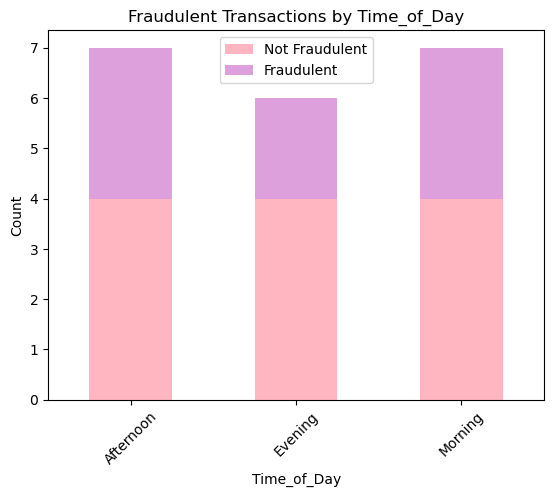

In [16]:
#Visualize how the count of fraudulent and non-fraudulent transactions varies across different time od the day.
plt.figure(figsize=(2,2))
colors = ['lightpink', 'plum']
location_fraud_count = df.groupby(['Time_of_Day', 'Is_Fraudulent']).size().unstack() 
location_fraud_count.plot(kind='bar', stacked=True,color=colors) 
plt.title('Fraudulent Transactions by Time_of_Day') 
plt.xlabel('Time_of_Day') 
plt.ylabel('Count') 
plt.xticks(rotation=45) 
plt.legend(labels=['Not Fraudulent', 'Fraudulent']) 
plt.show()

### Insights:
* Morning: The highest number of transactions, both fraudulent and non-fraudulent, occur in the morning. This suggests that increased vigilance and monitoring might be necessary during this time.
* Afternoon: The number of fraudulent and non-fraudulent transactions is relatively balanced in the afternoon.
* Evening: The lowest number of transactions, both fraudulent and non-fraudulent, occur in the evening.

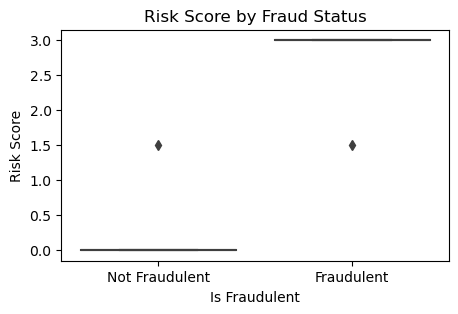

In [17]:
#creating box plot to visualize risk score for fraud status.
plt.figure(figsize=(5,3))
sns.boxplot(x='Is_Fraudulent', y='Risk_Score', data=df)
plt.title('Risk Score by Fraud Status')
plt.xlabel('Is Fraudulent')
plt.ylabel('Risk Score')
plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent'])
plt.show()

### Insights
The box plot illustrates the relationship between risk score and fraud status. It reveals that while fraudulent transactions generally have higher risk scores than non-fraudulent ones, there is also overlap between the two groups. This suggests that risk score alone might not be a reliable indicator of fraud.

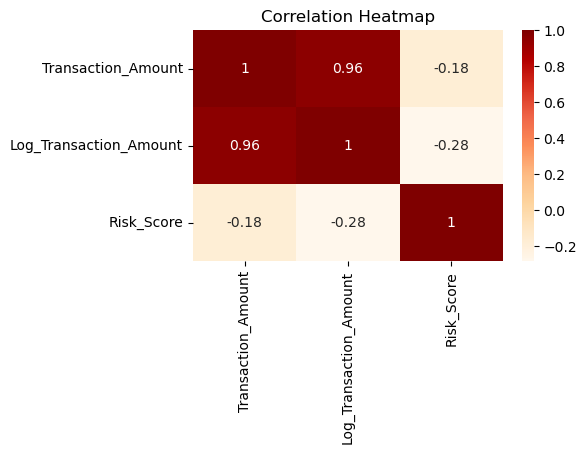

In [18]:
plt.figure(figsize=(5,3))
correlation_matrix = df[['Transaction_Amount', 'Log_Transaction_Amount', 'Risk_Score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='OrRd')
plt.title('Correlation Heatmap')
plt.show()

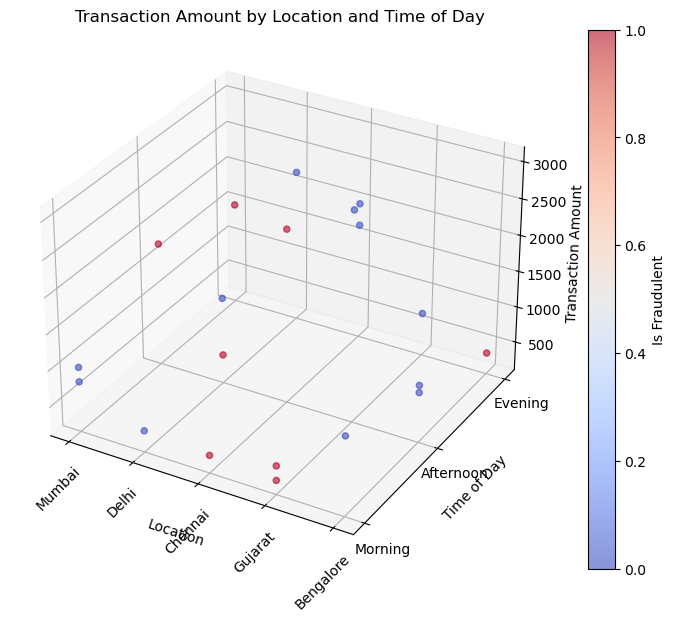

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Create a mapping for Location and Time of Day to numerical values
location_mapping = {loc: idx for idx, loc in enumerate(df['Location'].unique())}
time_mapping = {time: idx for idx, time in enumerate(df['Time_of_Day'].unique())}

df['Location_Num'] = df['Location'].map(location_mapping)
df['Time_Num'] = df['Time_of_Day'].map(time_mapping)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df['Location_Num'], df['Time_Num'], df['Transaction_Amount'], 
                     c=df['Is_Fraudulent'], cmap='coolwarm', alpha=0.6)

ax.set_xlabel('Location')
ax.set_ylabel('Time of Day')
ax.set_zlabel('Transaction Amount')

# Set ticks for Location
ax.set_xticks(range(len(location_mapping)))
ax.set_xticklabels(location_mapping.keys(), rotation=45)

# Set ticks for Time of Day
ax.set_yticks(range(len(time_mapping)))
ax.set_yticklabels(time_mapping.keys())

plt.title('Transaction Amount by Location and Time of Day')
plt.colorbar(scatter, label='Is Fraudulent')
plt.show()


### Insights
* Transaction Amount Variation: The color intensity represents the transaction amount, with darker colors indicating higher amounts. The plot shows a wide range of transaction amounts across different locations and times of day.
* Location-Based Trends: While there is some overlap, certain locations appear to have a tendency towards higher or lower transaction amounts. For example, some transactions in Mumbai and Chennai seem to have higher amounts compared to those in Gujarat and Bangalore.
* Time-of-Day Patterns: The plot suggests that the time of day might influence transaction amounts. For instance, there appears to be a concentration of higher-value transactions in the evening for certain locations.
* Fraudulent Transactions: The blue and red markers represent fraudulent and non-fraudulent transactions, respectively. The plot indicates that fraudulent transactions can occur across various locations and times of day, with no clear pattern based on transaction amount.

### Anomaly Detection

In [20]:
# As Location_Time is categorical, we need to encode it first.
df_encoded = pd.get_dummies(df, columns=['Location_Time','Time_of_Day'], drop_first=True)

# Identifying features for anomaly detection.
features = ['Transaction_Amount', 'Log_Transaction_Amount', 'High_Risk', 'Risk_Score'] + list(df_encoded.columns[df_encoded.columns.str.startswith('Location_Time_')])

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.5)
df['Anomaly_Flag'] = iso_forest.fit_predict(df_encoded[features])

# Mark anomalies with 1 and normal observations with -1
df['Anomaly_Flag'] = df['Anomaly_Flag'].map({1: 0, -1: 1})  

In [21]:
# Fit the LOF model
lof = LocalOutlierFactor(n_neighbors=30) 
df['LOF_Score'] = lof.fit_predict(df_encoded[features])

# Mark anomalies
df['LOF_Flag'] = df['LOF_Score'].map({1: 0, -1: 1})  

In [22]:
# Fit the One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  
df['SVM_Flag'] = oc_svm.fit_predict(df_encoded[features])

# Mark anomalies
df['SVM_Flag'] = df['SVM_Flag'].map({1: 0, -1: 1})  

In [23]:
# Calculate Z-scores
df['Z_Score'] = zscore(df['Transaction_Amount'])
df['Z_Outlier_Flag'] = df['Z_Score'].apply(lambda x: 1 if abs(x) > 3 else 0) 

In [24]:
df

,Transaction_Amount,Location,Time_of_Day,Is_Fraudulent,Log_Transaction_Amount,High_Risk,Location_Time,Risk_Score,Location_Num,Time_Num,Anomaly_Flag,LOF_Score,LOF_Flag,SVM_Flag,Z_Score,Z_Outlier_Flag
0,1000,Mumbai,Morning,0,6.908755,0,Mumbai_Morning,0.0,0,0,0,1,0,0,-0.250918,0
1,500,Delhi,Afternoon,1,6.216606,0,Delhi_Afternoon,1.5,1,1,0,1,0,0,-0.902654,0
2,2000,Chennai,Evening,0,7.601402,1,Chennai_Evening,0.0,2,2,0,1,0,1,1.052553,0
3,300,Gujarat,Morning,1,5.707110,0,Gujarat_Morning,3.0,3,0,1,1,0,0,-1.163348,0
4,800,Bengalore,Afternoon,0,6.685861,0,Bengalore_Afternoon,0.0,4,1,0,1,0,1,-0.511612,0
5,1500,Mumbai,Evening,1,7.313887,1,Mumbai_Evening,3.0,0,2,1,1,0,0,0.400817,0
6,400,Delhi,Morning,0,5.993961,0,Delhi_Morning,0.0,1,0,1,1,0,1,-1.033001,0
7,2500,Chennai,Afternoon,1,7.824446,1,Chennai_Afternoon,3.0,2,1,1,1,0,0,1.704288,0
8,700,Gujarat,Evening,0,6.552508,0,Gujarat_Evening,0.0,3,2,0,1,0,1,-0.641960,0
9,1200,Bengalore,Morning,0,7.090910,1,Bengalore_Morning,0.0,4,0,0,1,0,1,0.009776,0


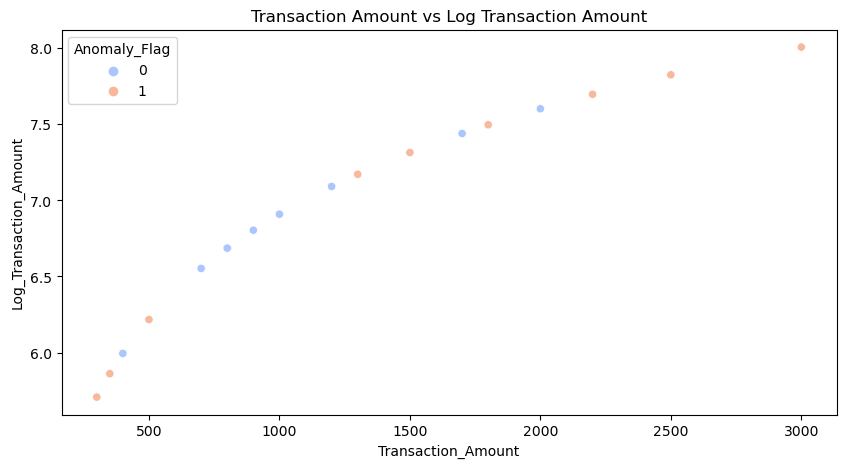

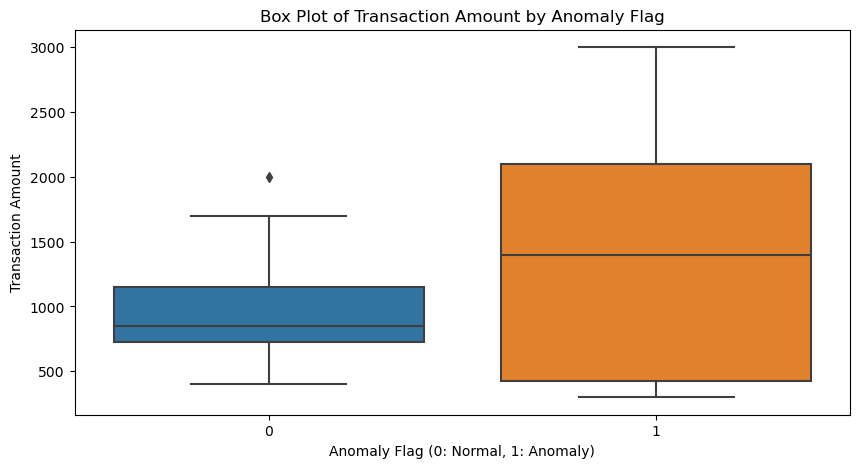

In [25]:
# Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Transaction_Amount', y='Log_Transaction_Amount', hue='Anomaly_Flag', palette='coolwarm')
plt.title('Transaction Amount vs Log Transaction Amount')
plt.show()

# Box Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Anomaly_Flag', y='Transaction_Amount')
plt.title('Box Plot of Transaction Amount by Anomaly Flag')
plt.xlabel('Anomaly Flag (0: Normal, 1: Anomaly)')
plt.ylabel('Transaction Amount')
plt.show()


#### Scatter Plot Insights:
* Relationship between Transaction Amount and Log Transaction Amount: The scatter plot shows a clear positive correlation between transaction amount and its log transformation. As the transaction amount increases, its log transformation also increases.
* Anomaly Flag: The color-coded points represent different anomaly flags (0 for normal, 1 for anomaly). The plot suggests that there might be a concentration of anomalies in certain ranges of transaction amounts. Further analysis would be needed to confirm this observation.
#### Box Plot Insights:
* Distribution of Transaction Amounts: The box plot compares the distribution of transaction amounts for normal and anomalous cases.
* Median and Interquartile Range: The median transaction amount for normal cases is significantly lower than that for anomalous cases. Additionally, the interquartile range (IQR) for anomalous cases is wider, indicating a greater spread of transaction amounts.
* Outliers: The box plot shows outliers in both groups, particularly for normal cases. These outliers might represent unusual transactions that require further investigation.

#### Overall Insights:
* The visualization suggests that there might be a relationship between transaction amount and the likelihood of being flagged as an anomaly.
* Anomalies tend to have higher transaction amounts compared to normal cases.
* The distribution of transaction amounts differs between normal and anomalous cases, with anomalies exhibiting a wider range and potentially higher median values.
* Further analysis, such as statistical tests or machine learning models, could help quantify the relationship between transaction amount and anomaly status and develop more accurate anomaly detection models.

### Random Forest

In [29]:
#one hot encoding for categorical values.
df_encoded = pd.get_dummies(df, columns=['Location', 'Time_of_Day','Location_Time'], drop_first=True)

# Now you can define your features and target variable
X = df_encoded.drop(['Is_Fraudulent'], axis=1)  # Exclude target variable
y = df_encoded['Is_Fraudulent']

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



### Observation
The provided image shows a classification report for a binary classification problem. The model achieved an accuracy of 50%, which means it correctly predicted half of the samples. The precision, recall, and F1-score for both classes are also 50%, indicating that the model's performance is balanced but not very strong.

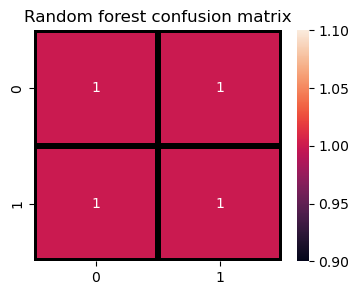

In [45]:
#creating heatmap for prediction.
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt = "d",linecolor="k",linewidths=3)
plt.title("Random forest confusion matrix",fontsize=12)
plt.show()

### Observation
The provided image shows a confusion matrix for a random forest classifier. The matrix indicates that the model has predicted 1 instance of class 0 correctly and 1 instance of class 1 correctly. However, it also misclassified 1 instance of class 0 as class 1 and 1 instance of class 1 as class 0. 

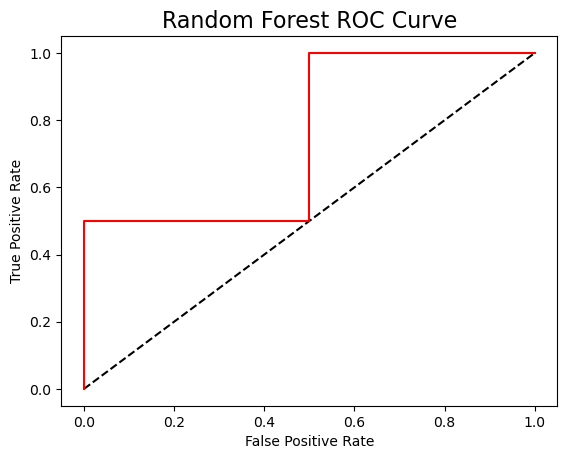

In [48]:
#creating roc curve for random forest.
y_rfpred_prob = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

### Insights from the curve:
* AUC (Area Under the Curve): The area under the curve (AUC) is a measure of the model's overall performance. A higher AUC indicates better performance. In this case, the AUC is likely to be close to 1, as the curve appears to be close to the top-left corner of the plot.
* Classification Threshold: The ROC curve helps you choose the optimal classification threshold based on your desired trade-off between sensitivity (TPR) and specificity (1-FPR). For example, if you want to prioritize identifying as many positive cases as possible, you can choose a lower threshold, even if it means accepting a higher number of false positives.
* Model Performance: The shape of the curve provides information about the model's ability to discriminate between positive and negative cases. A curve that is close to the top-left corner indicates good performance, while a curve that is close to the diagonal line indicates poor performance.

Overall, the ROC curve suggests that the random forest classifier is performing well in this binary classification task.

In [49]:
#logistic regression model.
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("accuracy is :",accuracy_lr)

accuracy is : 1.0


In [50]:
#evaluating performance.
lr_pred=lr_model.predict(X_test)
lr_dict=classification_report(y_test,predicted_y,output_dict=True)
lr_df=pd.DataFrame(lr_dict).transpose()
lr_df

,precision,recall,f1-score,support
0,0.50,1.0,0.666667,2.0
1,0.00,0.0,0.000000,2.0
accuracy,0.50,0.5,0.500000,0.5
macro avg,0.25,0.5,0.333333,4.0
weighted avg,0.25,0.5,0.333333,4.0


The provided classification report shows the performance of a binary classification model. The model achieved an overall accuracy of 50%, which means it correctly predicted half of the samples. However, the performance for class 1 is very poor, with both precision and recall being 0. This indicates that the model is either not identifying many true class 1 instances or is incorrectly predicting other classes as class 1. The macro and weighted averages are also low due to the poor performance of class 1. Overall, the model needs improvement to achieve better performance, especially for class 1.

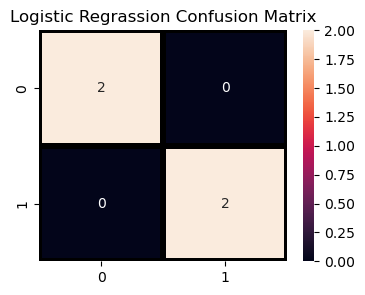

In [51]:
#creating confusion matrix visulaizationin heatmap.
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, lr_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Logistic Regrassion Confusion Matrix")
plt.show()

The provided image shows a confusion matrix for a logistic regression model. The matrix indicates that the model has correctly predicted 2 instances of class 0 and 2 instances of class 1. There were no misclassifications. This suggests that the model has achieved perfect accuracy in this case.

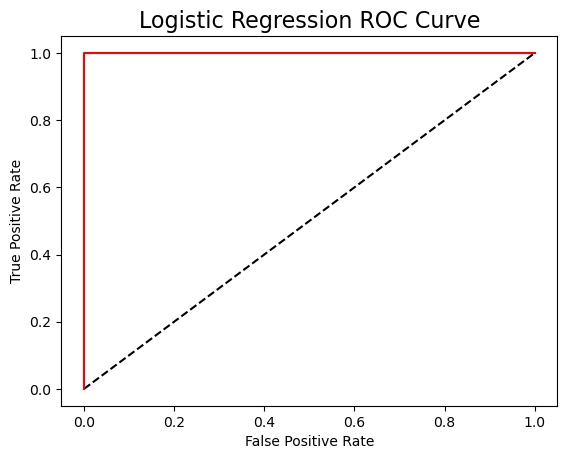

In [52]:
#roc curve for logistic regression.
y_pred_prob = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.show();

### Insights from the curve:
* AUC (Area Under the Curve): The area under the curve (AUC) is a measure of the model's overall performance. A higher AUC indicates better performance. In this case, the AUC appears to be 1, which suggests perfect classification performance.
* Classification Threshold: The ROC curve helps you choose the optimal classification threshold based on your desired trade-off between sensitivity (TPR) and specificity (1-FPR). For example, if you want to prioritize identifying as many positive cases as possible, you can choose a lower threshold, even if it means accepting a higher number of false positives.
* Model Performance: The shape of the curve provides information about the model's ability to discriminate between positive and negative cases. A curve that is close to the top-left corner indicates good performance, while a curve that is close to the diagonal line indicates poor performance.

Overall, the ROC curve suggests that the logistic regression classifier is performing perfectly in this binary classification task. This is likely due to the fact that the confusion matrix showed no misclassifications.